In [10]:
import pandas as pd
import numpy as np
import requests
import os

from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
import keras.backend as K

from utils.vocab import Vocabulary
from sklearn.cluster import KMeans
from joblib import load

from utils.plot_utils import plot_and_save_history
from sklearn.model_selection import train_test_split

### Utils for working with API

In [2]:
def download_sample():
    download_url = ""

    try:
        resp = requests.get(download_url)
        sample = resp.json()

        # Sort out invalid samples like {'error': 'You already downloaded this vector'}
        if set(sample.keys()) != set(valid_keys):
            failed["num"] += 1
            failed["responses"].append(resp.text)
            print("Invalid sample")
            print(failed)
            return None

    # Sometimes decoded samples are not valid json objects
    except ValueError:
        failed["num"] += 1
        try:
            failed["responses"].append(resp)
            print("Invalid response")
        # If download failed, resp is undound
        except UnboundLocalError:
            print("Bad URL")
            
        return None

    return sample

In [3]:
def upload_sample(classified_sample):
    upload_url = ""

    try:
        resp = requests.post(upload_url, classified_sample)
        return resp.text
    except:
        print("Download failed")
        return None

### Autoencoder model

In [18]:
class AutoEncoder(object):
    """ 4-layer LSTM Autoencoder
    Parameters
        vocab: Vocabulary object that stores char-to-int mappings 
            and text processing functions.
        hidden_size: Dimension of latent space between encoder and decoder.
            Default: 64.
        dropout: Fraction of units to be randomly ignored during training.
            Both linear and recurrent dropout are used.
            Default: 0.2.
    """
    DEFAULT_HIDDEN_UNITS = 64
    DEFAULT_DROPOUT = 0.2
    DEFAULT_BATCH_SIZE = 64
    DEFAULT_EPOCHS = 100
    DEFAULT_MODEL_WEIGHT_PATH = './models/autoencoder-weights.h5'
    model_name = 'autoencoder'

    def __init__(self, vocab, hidden_size=None, dropout=None):
        if not hidden_size:
            self.hidden_size = AutoEncoder.DEFAULT_HIDDEN_UNITS
        if not dropout:
            self.dropout = AutoEncoder.DEFAULT_DROPOUT
            
        self.vocab = vocab
        self.vocab_size = vocab.vocab_size
        self.max_input_seq_length = vocab.max_input_seq_length

        encoder_inputs = Input(shape=(None,), name='encoder_inputs')
        encoder_embedding = Embedding(input_dim=self.vocab_size,
                                      output_dim=self.hidden_size,
                                      input_length=self.max_input_seq_length,
                                      name='encoder_embedding')
        encoder_lstm = LSTM(units=self.hidden_size,
                            return_state=True,
                            dropout=self.dropout,
                            recurrent_dropout=self.dropout,
                            name='encoder_lstm')
        encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embedding(encoder_inputs))
        encoder_states = [encoder_state_h, encoder_state_c]

        decoder_inputs = Input(shape=(None, self.vocab_size), name='decoder_inputs')
        decoder_lstm = LSTM(units=self.hidden_size, return_state=True,
                            return_sequences=True, name='decoder_lstm')
        decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs,
                                                                         initial_state=encoder_states)
        decoder_dense = Dense(units=self.vocab_size, activation='softmax', name='decoder_dense')
        decoder_outputs = decoder_dense(decoder_outputs)

        model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

        model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

        self.model = model

        self.encoder_model = Model(encoder_inputs, encoder_states)

        decoder_state_inputs = [Input(shape=(self.hidden_size,)), Input(shape=(self.hidden_size,))]
        decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs,
                                                         initial_state=decoder_state_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        self.decoder_model = Model([decoder_inputs] + decoder_state_inputs,
                                   [decoder_outputs] + decoder_states)

    def load_weights(self, weight_file_path):
        if os.path.exists(weight_file_path):
            self.model.load_weights(weight_file_path)

    def generate_batch(self, samples, batch_size):
        num_batches = len(samples) // batch_size
        while True:
            for batchIdx in range(0, num_batches):
                start = batchIdx * batch_size
                end = (batchIdx + 1) * batch_size
                encoder_input_data_batch = pad_sequences(samples[start:end], self.max_input_seq_length)
                decoder_target_data_batch = np.zeros(shape=(batch_size, self.max_input_seq_length,
                                                            self.vocab_size))
                decoder_input_data_batch = np.zeros(shape=(batch_size, self.max_input_seq_length,
                                                           self.vocab_size))
                for textIdx, chars in enumerate(samples[start:end]):
                    for idx, char in enumerate(chars):
                        if char != 1: # not <UNK>
                            decoder_input_data_batch[textIdx, idx, char] = 1
                            if idx > 0:
                                decoder_target_data_batch[textIdx, idx - 1, char] = 1
                yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch

    def fit(self, Xtrain, Xtest, epochs=None, batch_size=None, weight_file_path=None):
        """
        Train model.
        Parameters:
            Xtrain: Array of strings for training.
            Xtest: Array of strings for validation.
            epochs: Number of full forward passes of all training samples.
                Default: 50.
            batch_size: Number of samples to pass for one iteration.
                Default: 64.
            weight_file_path: File path with extension '.h5'
                for saving weights of the network. (https://www.h5py.org/)
                Default: ./models/autoencoder-weights.h5
        """

        if not epochs:
            epochs = AutoEncoder.DEFAULT_EPOCHS
        if not batch_size:
            batch_size = AutoEncoder.DEFAULT_BATCH_SIZE
        if not weight_file_path:
            weight_file_path = AutoEncoder.DEFAULT_WEIGHT_FILE_PATH

        checkpoint = ModelCheckpoint(weight_file_path)

        Xtrain = self.vocab.transform_texts(Xtrain)
        Xtest = self.vocab.transform_texts(Xtest)

        train_gen = self.generate_batch(Xtrain, batch_size)
        test_gen = self.generate_batch(Xtest, batch_size)

        train_num_batches = len(Xtrain) // batch_size
        test_num_batches = len(Xtest) // batch_size

        history = self.model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                                           epochs=epochs, verbose=True,
                                           validation_data=test_gen, validation_steps=test_num_batches,
                                           callbacks=[checkpoint])
        self.model.save_weights(weight_file_path)
        return history

    def predict(self, input_text):
        """
        Process input texts and reconstruct them.
        Used to check how well model "understands" input texts.
        Parameters:
             input_text: 
        """
        input_seq = self.vocab.transform_texts([input_text])
        states_value = self.encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, self.vocab_size))
        target_seq[0, 0, self.vocab.char2idx['<START>']] = 1
        target_text = ''
        target_text_len = 0
        terminated = False
        while not terminated:
            output_tokens, h, c = self.decoder_model.predict([target_seq] + states_value)

            sample_token_idx = np.argmax(output_tokens[0, -1, :])
            sample_char = self.vocab.idx2char[sample_token_idx]
            target_text_len += 1

            if sample_char != '<START>' and sample_char != '<END>':
                target_text += ' ' + sample_char

            if sample_char == '<END>' or target_text_len >= self.max_input_seq_length:
                terminated = True

            target_seq = np.zeros((1, 1, self.vocab_size))
            target_seq[0, 0, sample_token_idx] = 1

            states_value = [h, c]
        return target_text.strip()    

### Text processing

In [5]:
def get_features(vectors):
    # vector: string -> vector_embedding: [char_indices]
    # [char_indices] are padded with 0 to the right
    vector_embedding = vocab.transform_texts([vector])
    
    # vector_embedding: [char_indices] -> encoders_states: [state_h, state_c]
    encoder_states = encoder.predict([vector_embedding])
    
    # use state_h as feature
    vector_features = encoder_states[0]
    
    return vector_features

### Prediction

In [6]:
def predict_class(vector_features):
    vector_class = kmeans.predict(vector_features)[0]
    # "0"-class is invalid
    if vector_class == 0:
        vector_class = 25
    return vector_class

### Main code

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"] = ''

vocab = Vocabulary()
vocab.load_vocab('vocab.json')
autoencoder = AutoEncoder(vocab)
autoencoder.load_weights('./models/autoencoder-weights.h5')
encoder = autoencoder.encoder_model
kmeans = load('./models/kmeans-weights.joblib')


# make valid template
valid_keys = ("id", "vector")
samples = pd.DataFrame(columns=valid_keys)
failed = {"num": 0, "responses": []}
num_samples = 1

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
for i in range(num_samples):
    print(i, end=' ')
    sample = download_sample()
    # if sample is invalid, continue to next one 
    if sample == None:
        continue
    # make prediction
    vector = sample['vector']
    vector_features = get_features(vector)
    vector_class = predict_class(vector_features)
    # upload result
    sample['class'] = vector_class
    classified_vector = {"vector": sample["id"], "class": sample["class"]}
    upload_sample(classified_vector)
    # save sample for further training
    samples = samples.append([sample], sort=True)

print("Finished!")

samples = samples.reset_index(drop=True)
samples.to_csv('./vectors/samples-script.csv', index=False)

0 {
	"message": "class was stored successfully"
}

Finished!


### Train

In [24]:
data = pd.read_csv('vectors/sample-requests.csv')
data = data['vector']
data = data.fillna('<BLANK>')
train_data, test_data = train_test_split(data, test_size=0.5)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

**Train autoencoder**

In [28]:
os.environ["CUDA_VISIBLE_DEVICES"] = ''

vocab = Vocabulary()
vocab.load_vocab('vocab.json')
train_autoencoder = AutoEncoder(vocab)
train_encoder = train_autoencoder.encoder_model
weight_file_path = "./models/train-for-fun.h5"
report_dir_path = "./reports"

start fitting ...
Epoch 1/10
62/62 [==============================] - 11s 177ms/step - loss: 4.0529 - acc: 0.1987 - val_loss: 3.6374 - val_acc: 0.2365


/home/bnv/research/venv/lib/python3.6/site-packages/keras/engine/network.py:877: UserWarning: Layer decoder_lstm was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_lstm_5/while/Exit_3:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'encoder_lstm_5/while/Exit_4:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/10
62/62 [==============================] - 9s 147ms/step - loss: 3.6165 - acc: 0.2206 - val_loss: 3.4311 - val_acc: 0.2361
Epoch 3/10
62/62 [==============================] - 9s 148ms/step - loss: 3.4792 - acc: 0.2261 - val_loss: 3.3597 - val_acc: 0.2310
Epoch 4/10
62/62 [==============================] - 9s 148ms/step - loss: 3.3780 - acc: 0.2326 - val_loss: 3.2946 - val_acc: 0.2271
Epoch 5/10
62/62 [==============================] - 9s 149ms/step - loss: 3.3201 - acc: 0.2529 - val_loss: 3.2655 - val_acc: 0.2339
Epoch 6/10
62/62 [==============================] - 9s 148ms/step - loss: 3.2512 - acc: 0.2571 - val_loss: 3.2351 - val_acc: 0.2352
Epoch 7/10
62/62 [==============================] - 9s 148ms/step - loss: 3.2059 - acc: 0.2629 - val_loss: 3.2084 - val_acc: 0.2394
Epoch 8/10
62/62 [==============================] - 9s 148ms/step - loss: 3.1541 - acc: 0.2681 - val_loss: 3.1676 - val_acc: 0.2535
Epoch 9/10
62/62 [==============================] - 9s 148ms/step - loss: 3.

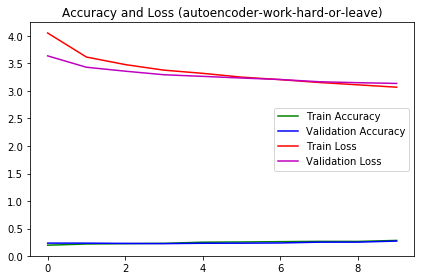

In [29]:
print('start fitting ...')
history = train_autoencoder.fit(train_data, test_data, 
                                epochs=10, batch_size=1,
                                weight_file_path=weight_file_path)

comment = "work-hard-or-leave"
history_plot_file_path = f"{ report_dir_path }/{ AutoEncoder.model_name }-{ comment }-history.png"
plot_and_save_history(history, f"{AutoEncoder.model_name}-{comment}", history_plot_file_path, metrics={'loss', 'acc'})

**Train K-Means**

In [30]:
# vector: 1d array of strings -> vector_embeddings: 2d array of char_indices for each string
# [char_indices] are padded with 0 to the right
vector_embeddings = vocab.transform_texts(train_data)

# vector_embeddings: [[char_indices]] -> encoders_states: [state_h, state_c]
encoder_states = encoder.predict(vector_embeddings)

# use state_h as feature
vector_features = encoder_states[0]

In [31]:
vector_embeddings

array([[10, 37, 73, ..., 72, 90, 34],
       [10,  8,  8, ...,  8,  2, 34],
       [10, 76, 64, ...,  0,  0,  0],
       ...,
       [10, 19, 46, ..., 69, 61, 34],
       [10, 74, 22, ..., 29, 16, 34],
       [10, 35,  3, ...,  2,  9, 34]], dtype=int32)

In [32]:
encoder_states

[array([[-1.0748301e-02, -4.0933765e-02,  1.4602272e-01, ...,
          0.0000000e+00, -7.3291981e-01,  4.3702862e-01],
        [ 2.9854108e-02,  7.4152969e-02,  3.2208309e-01, ...,
          0.0000000e+00, -3.1364110e-01, -7.6583880e-03],
        [-6.8200123e-01,  1.0296957e-02,  5.9077860e-04, ...,
          3.5076741e-02,  7.0074257e-03,  5.3584874e-01],
        ...,
        [-0.0000000e+00, -4.0243890e-02,  5.4632151e-01, ...,
          0.0000000e+00, -7.9335093e-01, -6.3876206e-01],
        [ 1.3621312e-01, -0.0000000e+00,  4.7489369e-01, ...,
          0.0000000e+00,  2.9663006e-02, -0.0000000e+00],
        [-4.1232555e-04,  0.0000000e+00,  5.2863806e-01, ...,
          0.0000000e+00, -2.9216364e-01,  4.6535716e-03]], dtype=float32),
 array([[-4.9827792e-02, -2.5937207e+00,  3.0500510e-01, ...,
          1.2791494e+00, -5.6390400e+00,  1.0864618e+00],
        [ 3.1825617e-02,  5.2875276e+00,  6.9271779e-01, ...,
          1.3682374e+01, -6.5257388e-01, -1.5014127e-01],
        [-

In [33]:
vector_features

array([[-1.0748301e-02, -4.0933765e-02,  1.4602272e-01, ...,
         0.0000000e+00, -7.3291981e-01,  4.3702862e-01],
       [ 2.9854108e-02,  7.4152969e-02,  3.2208309e-01, ...,
         0.0000000e+00, -3.1364110e-01, -7.6583880e-03],
       [-6.8200123e-01,  1.0296957e-02,  5.9077860e-04, ...,
         3.5076741e-02,  7.0074257e-03,  5.3584874e-01],
       ...,
       [-0.0000000e+00, -4.0243890e-02,  5.4632151e-01, ...,
         0.0000000e+00, -7.9335093e-01, -6.3876206e-01],
       [ 1.3621312e-01, -0.0000000e+00,  4.7489369e-01, ...,
         0.0000000e+00,  2.9663006e-02, -0.0000000e+00],
       [-4.1232555e-04,  0.0000000e+00,  5.2863806e-01, ...,
         0.0000000e+00, -2.9216364e-01,  4.6535716e-03]], dtype=float32)

In [35]:
train_kmeans = KMeans(n_clusters=25, n_init=20, n_jobs=-1)
train_labels = train_kmeans.fit_predict(vector_features)
train_kmeans_result = pd.DataFrame(train_data)
train_kmeans_result['class'] = train_labels

In [36]:
train_kmeans_result

,vector,class
0,wqT_3QLpB_BC6QMAAAMA1gAFAQiRzMzTBRDW2_SxsKbaoC...,0
1,../../../../../../../../../../../../localstart...,4
2,?%3F%253F%25253F%252525253Fclear_cache,11
3,dTM7k!M4/K@KUGheyjA96qBI#)2g^g5k4wbÃf]go@V!]J...,13
4,"Tue, 25 Jul 2017 08:01:15 GMT",8
5,13{{`ls -la;factor 228000`}},3
6,POST\';\'XMLHttpRequest\';\'14b1cb4144fff12271...,21
7,"CB@5==OO >H81:0, ?>?@>1C9B5 >1@0B8BLAO ?>765/{...",7
8,Mozilla/5.0 (Linux; U; Android 5.0.2; id; Andr...,2
9,m8Vs4hRYuefKwKyyaIan6HIzrcha3Nnqo IuND6SKONUzy...,5
